## Dependencias

In [21]:
import numpy as np
import pandas as pd 

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from varclushi import VarClusHi
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
cf.go_offline() 
pd.set_option('display.max_columns', None)

## Cargar datos

In [29]:
data = pd.read_csv('data.csv')
data.shape

(329, 21)

In [30]:
data.head(3)

,N°,DELEGACION,MERCADO,NUM_OFIC,NUM_LOCALE,Coord_Y,Coord_X,DIRECCION,COLONIA,TIPO,SUPERF_M2,INAUGURACI,ANTIGÜEDA,VOCACIÓN,DETALLE,FORMA,NIVELES,TAMAÑO1,PROTEGIDO,COORGEOG_X,COORGEOG_Y
0,18.0,AZCAPOTZALCO,AZCAPOTZALCO,35.0,546.0,2.154268e+06,480539.52674,AV. AZCAPOTZALCO ENTRE ESPERANZA Y RAYON,AZCAPOTZALCO,TRADICIONAL,9346.0,1957.0,63.0,N/D,N/D,CUADRO,1,MEDIANO,SI,-99.185439,19.482872
1,20.0,AZCAPOTZALCO,CLAVERIA,46.0,98.0,2.152290e+06,480987.33324,IRAPUATO Y CLAVERIA S/N,CLAVERIA,TRADICIONAL,2063.0,1947.0,73.0,N/D,N/D,CUADRO,1,CHICO,NO,-99.181152,19.465003
2,17.0,AZCAPOTZALCO,ARENAL,125.0,198.0,2.152428e+06,484181.95416,ALAMO Y CALLE 6 ENTRE OLIVO Y CALLE 6,ARENAL,TRADICIONAL,3129.0,1963.0,57.0,N/D,N/D,RECTANGULO,1,CHICO,SI,-99.150715,19.466271


In [31]:
um = ['N°','MERCADO']
varc = ['NUM_LOCALE','SUPERF_M2','ANTIGÜEDA','NIVELES','COORGEOG_Y','COORGEOG_X']
vard = ['DELEGACION','TIPO','PROTEGIDO','FORMA']

In [32]:
data = data[um+varc+vard]

In [33]:
data.head()

,N°,MERCADO,NUM_LOCALE,SUPERF_M2,ANTIGÜEDA,NIVELES,COORGEOG_Y,COORGEOG_X,DELEGACION,TIPO,PROTEGIDO,FORMA
0,18.0,AZCAPOTZALCO,546.0,9346.0,63.0,1,19.482872,-99.185439,AZCAPOTZALCO,TRADICIONAL,SI,CUADRO
1,20.0,CLAVERIA,98.0,2063.0,73.0,1,19.465003,-99.181152,AZCAPOTZALCO,TRADICIONAL,NO,CUADRO
2,17.0,ARENAL,198.0,3129.0,57.0,1,19.466271,-99.150715,AZCAPOTZALCO,TRADICIONAL,SI,RECTANGULO
3,29.0,PROHOGAR,641.0,7167.0,57.0,1,19.475848,-99.153559,AZCAPOTZALCO,TRADICIONAL,NO,CUADRO
4,33.0,SANTA LUCIA,150.0,3116.0,56.0,1,19.476417,-99.196399,AZCAPOTZALCO,TRADICIONAL,NO,CUADRO


In [36]:
data.columns = ['id','nombre','c_num_locales','c_sup','c_antiguedad','c_niveles',
'c_lat','c_lon','d_delegacion','d_tipo','d_protegido','d_forma']
varc = [v for v in data.columns if v[0]=='c']
vard = [v for v in data.columns if v[0]=='d']
len(varc),len(vard)

(6, 4)

In [37]:
for v in varc:
    data[v] = pd.to_numeric(data[v],errors='coerce')

In [38]:
for v in vard:
    data[v] = data[v].fillna('MISSING')
    display(data[v].value_counts())

d_delegacion
GUSTAVO A. MADERO      51
VENUSTIANO CARRANZA    42
CUAUHTÉMOC             39
COYOACÁN               22
IZTAPALAPA             20
TLALPAN                20
MIGUEL HIDALGO         19
AZCAPOTZALCO           19
TLÁHUAC                18
ÁLVARO OBREGÓN         16
BENITO JUÁREZ          16
IZTACALCO              16
XOCHIMILCO             11
MILPA ALTA             10
MAGDALENA CONTRERAS     5
CUAJIMALPA              5
Name: count, dtype: int64

d_tipo
TRADICIONAL                  276
ESPECIALIZADO                 44
TURISTICO Y ESPECIALIZADO      7
TRADICIONAL Y TURISTICO        2
Name: count, dtype: int64

d_protegido
NO    287
SI     42
Name: count, dtype: int64

d_forma
CUADRO         159
RECTANGULO     137
IRREGULAR       28
CIRCULO          4
RECTANGULAR      1
Name: count, dtype: int64

In [39]:
data['d_forma'].replace({'RECTANGULAR':'RECTANGULO'},inplace=True)

## Análisis exploratorio de datos

### Ausentes

In [40]:
data[varc].isnull().sum()

c_num_locales    0
c_sup            0
c_antiguedad     0
c_niveles        0
c_lat            0
c_lon            0
dtype: int64

### Multicolinealidad

In [41]:
vc = VarClusHi(data[varc],feat_list=varc).varclus()

In [42]:
vc.rsquare.sort_values(by=['Cluster','RS_Ratio'])

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,c_num_locales,0.884384,0.001202,0.115755
1,0,c_sup,0.876755,0.005430,0.123918
2,0,c_lat,0.171338,0.008720,0.835952
5,1,c_lon,0.513089,0.003733,0.488736
4,1,c_niveles,0.387847,0.001093,0.612822
3,1,c_antiguedad,0.283742,0.001649,0.717441


In [43]:
mc = ['c_num_locales','c_lat','c_lon','c_antiguedad']

### Univariado

/home/jose/entornos/tse/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



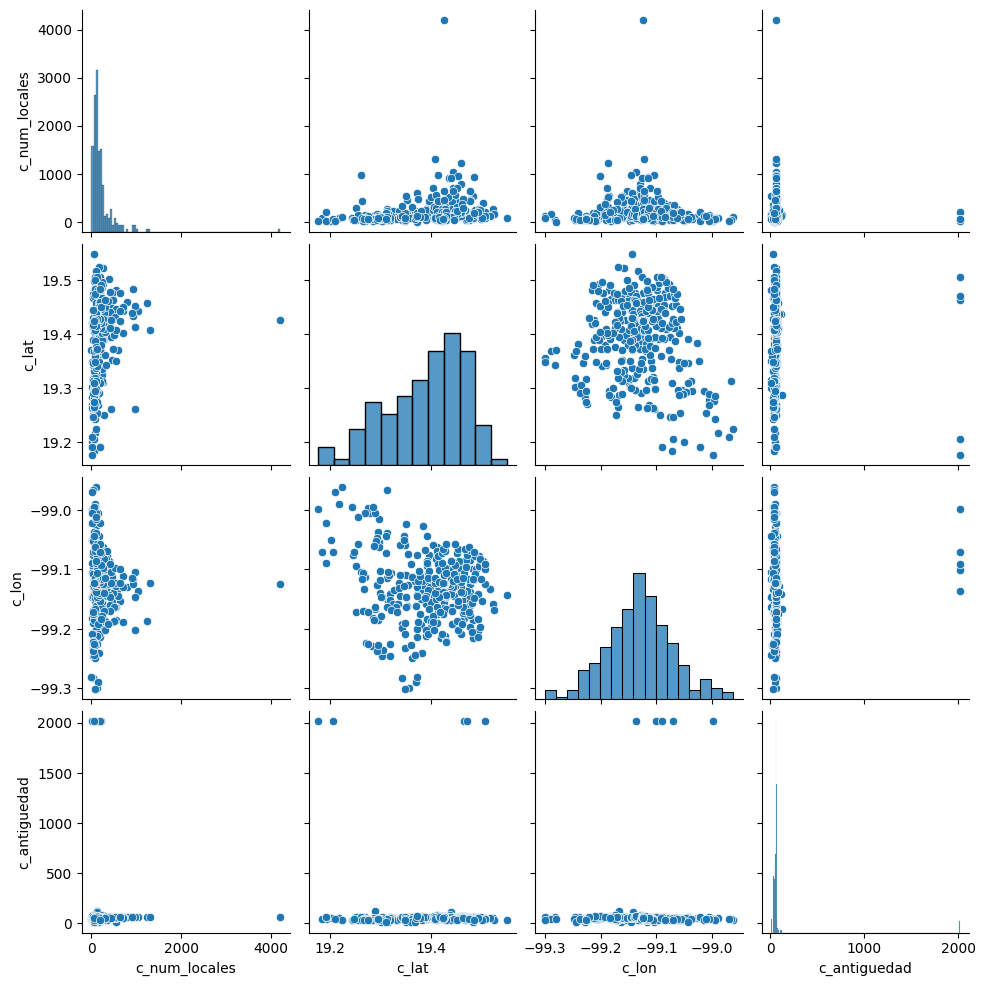

In [44]:
sns.pairplot(data[mc])

## Transformación de espacios

### Natural $\mathcal{X} $ 

In [46]:
X = data[mc].copy()

### Híper-caja $\mathcal{X}_{[0,1]}$

In [47]:
sc = MinMaxScaler()
X01 = pd.DataFrame(sc.fit_transform(X),columns=X.columns)

### PCA $\mathcal{X}_{p} $ 

In [54]:
pipe = make_pipeline(StandardScaler(),PCA(n_components=3),MinMaxScaler())
Xp = pd.DataFrame(pipe.fit_transform(X),columns=['p1','p2','p3'])
pipe.steps[1][1].explained_variance_ratio_.cumsum()

array([0.33049195, 0.5882677 , 0.82081363])

In [63]:
um = ['id','nombre']

In [64]:
X[um] = X01[um] = Xp[um] = data[um]

## Inspección visual de los clusters

In [65]:
Xp.iplot(kind='scatter3d',x='p1',y='p2',z='p3',mode='markers',size=10,color='purple', text='nombre')
